In [1]:
import os
import tqdm

%matplotlib widget
import matplotlib
import matplotlib.pyplot

import datetime
import pytz

import pandas
import numpy

import scipy

import accels_utils.frame_accels as FA

In [2]:
# Processing initialization

COMPUTER    = 'sting'
root_path   = '/Users/matthieu/.ssh/ssh_to_graz/accdata2023/'+COMPUTER+'/'

ACC_NUMBER  = 10
AXIS        = ['X', 'Y', 'Z']

month       = '09'
day         = '21'

data_path   = root_path + month + '/' + day + '/'
proc_path   = root_path + 'processed_data/' + month + '/' + day + '/'

if not(os.path.isdir(proc_path)):
    os.makedirs(proc_path, exist_ok=True)

In [3]:
# Files list for the day
files_list = sorted([x for x in os.listdir(data_path) if x.startswith('acc') and x.endswith('.txt')])
print('Discovered {} files for the day (expected {})'.format(len(files_list), 6*24)) # one every 10 minutes

Discovered 143 files for the day (expected 144)


In [4]:
# Data extraction : taking 4 mins for 144 files (1 regular day)
data = {}
for fname_i, fname in enumerate(files_list):
    try:
        with open(data_path + fname) as accfile:
            dat = accfile.readlines()
        data[fname_i] = {}
        data[fname_i]['data'] = FA.extract_data(dat)
        data[fname_i]['ts']  = datetime.datetime.strptime(fname.split('.')[0].split('_')[-1][2:-3], '%y-%m-%dT%H%M%S')
    except : 
        print('There was a problem reading file {}'.format(fname))
    
    # if fname_i > 50:
    #     break

100%|██████████| 13714/13714 [00:02<00:00, 5891.96it/s]


In [5]:
energies = []
for rec in data.keys():
    energy = {}
    energy['ts'] = data[rec]['ts']
    for acc in data[rec]['data'].keys():
        if acc in range(1,ACC_NUMBER+1):
            for axis in data[rec]['data'][acc].keys():
                signal = numpy.array(data[rec]['data'][acc][axis]['val'])
                filtered_signal = FA.butter_lowpass_filter(signal, 5, 1600)
                energy[str(acc)+axis] = numpy.mean(numpy.power(filtered_signal, 2))
    energies.append(energy)
energies = pandas.DataFrame.from_dict(energies)

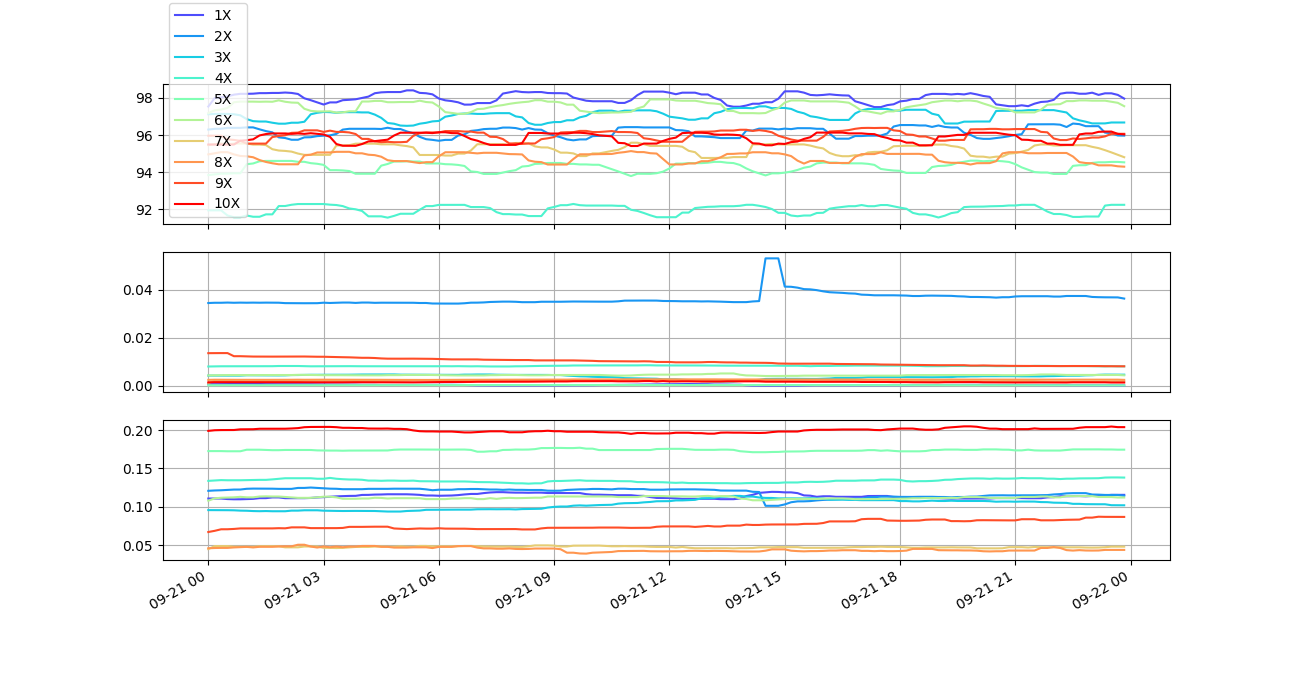

In [6]:
cmap = matplotlib.cm.get_cmap('rainbow')

fig, ax = matplotlib.pyplot.subplots(len(AXIS), 1, figsize=(13,7), sharex=True)
for axis_id, axis in enumerate(AXIS):
    for acc in range(1, ACC_NUMBER+1):
        ax[axis_id].plot(energies.ts, scipy.signal.medfilt(energies[str(acc)+axis], 5), c=cmap(float(acc)/ACC_NUMBER), label=str(acc)+axis)
    ax[axis_id].grid()
ax[0].legend()

matplotlib.pyplot.gcf().autofmt_xdate()
# fig.tight_layout()